# MNIST data set- Logistic Regression
https://en.wikipedia.org/wiki/MNIST_database

http://yann.lecun.com/exdb/mnist/

http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

It is a large database of handwritten digits that re used for training and image processing.

### IMPORT

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

### Load Data
I am using the tensorflow, since they have this in their tutorials.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('MNIST_data/',one_hot=True)
# The labels are loaded as one hot vector. I will convert them to digits from 0-9

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
#Separating the training and test datasets
X_train = data.train.images
y_train = np.argmax(data.train.labels, axis=1)#convert to digits

X_test = data.test.images
y_test = np.argmax(data.test.labels, axis=1)#convert to digits

In [4]:
print ("Size of training dataset = {}".format(X_train.shape[0]))
print ("Size of test dataset = {}".format(X_test.shape[0]))

# Each original image was is 28 X 28 and is flattended to a 784 1D array.
print ("Number of feature = {}".format(X_train.shape[1]))


Size of training dataset = 55000
Size of test dataset = 10000
Number of feature = 784


## Function to plot some digits

In [5]:
def plot_images(images, labels):
    fig, axes = plt.subplots(4,4)
    fig.subplots_adjust(hspace = 0.5,wspace = 0.5)
    
    for i,ax in zip(np.random.choice(range(images.shape[0]),16),axes.flat):
        ax.imshow(images[i].reshape(28,28),cmap='binary')
        ax.set_xlabel('label :{}'.format(labels[i]))
        ax.set_xticks([])
        ax.set_yticks([])
        

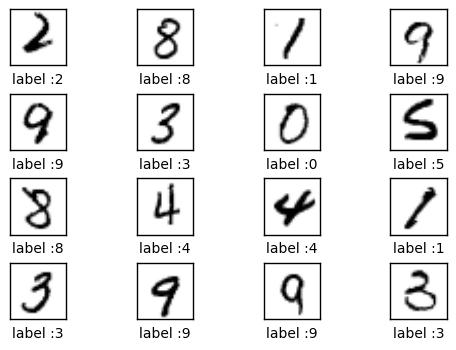

In [6]:
plot_images(X_test,y_test)

## Using Logistic Regression
First let's try all the features. After that we will perform PCA analysis to reduce the number of features and still get good prediction.

### Using Grid search to find the best C.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

parameters = {'C':[5**x for x in range(-1,3)]}

log_clf=  GridSearchCV(LogisticRegression(max_iter=100),param_grid=parameters,n_jobs=-1)

log_clf.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.2, 1, 5, 25]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [69]:
print ("The best parameter : {}".format(log_clf.best_params_))

The best parameter : {'C': 1}


### Predictions using all the features
Each original image was 28 X 28 pixel. It is flattened to a 1-D and this has 784 features.

In [102]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred_all = log_clf.predict(X_test)
print ("No. of features = {}".format(X_train.shape[1]))
print ("Classification Report :")
print (classification_report(y_true=y_test,y_pred=y_pred_all))

No. of features = 784
Classification Report :
             precision    recall  f1-score   support

          0       0.95      0.98      0.96       980
          1       0.96      0.98      0.97      1135
          2       0.94      0.89      0.91      1032
          3       0.90      0.91      0.90      1010
          4       0.92      0.93      0.92       982
          5       0.89      0.86      0.88       892
          6       0.94      0.95      0.94       958
          7       0.93      0.92      0.93      1028
          8       0.88      0.87      0.87       974
          9       0.90      0.89      0.90      1009

avg / total       0.92      0.92      0.92     10000



#### Plotting the confusion matrix and estimating accuracy

In [ ]:
cm1 = confusion_matrix(y_true=y_test,y_pred=y_pred_all)
print ("Confusion Matrix :")
print (cm1)
plt.matshow(cm1,cmap="Blues")
plt.colorbar()
plt.show()

print ("Accuracy = {}".format(np.trace(cm1)/len(y_test)))

While the accuracy of ~92% appears to be good, the best machine learning algorithms are performing significantly better on the MNIST dataset. 
Here we have used all the features in the image for training. Next, I use PCA to perform feature reduction.

## Performing PCA
I am trying to determine the number of components that would yield an accuracy score that is similar to what is achieved by using all the features. I am testing 10-100 components, and evaluating the total explained variance and the accuracy for each of them. 

In [72]:
from sklearn.decomposition import PCA

test_components = [10,20,30,40,50,60,70,80,90,100]
total_var_explained =[]
accuracy_score = []
for n in test_components:
    pca = PCA(n_components=n,whiten=True,svd_solver='full')
    
    pca.fit(X_train)
    
    total_var_explained.append(np.max(pca.explained_variance_ratio_.cumsum()))
    
    X_train_trans = pca.transform(X_train)
    X_test_trans = pca.transform(X_test)
    
    regr_temp = LogisticRegression(C=1)
    regr_temp.fit(X_train_trans,y_train)
    
    y_pred_temp = regr_temp.predict(X_test_trans)
    accuracy_temp = np.sum(y_test == y_pred_temp)/len(y_test)
    accuracy_score.append(accuracy_temp)
    
    

### Plotting and comparing the PCA 

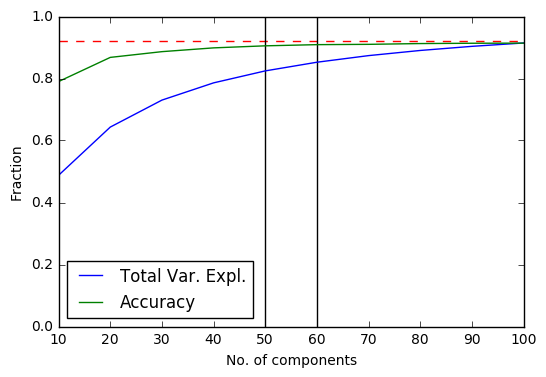

In [108]:
plt.plot(test_components,total_var_explained)
plt.plot(test_components,accuracy_score)
plt.legend(['Total Var. Expl.','Accuracy'],loc='best')
plt.ylabel('Fraction')
plt.xlabel('No. of components')
plt.hlines(0.9198,xmin=10,xmax=100,colors='r',linestyles='dashed')
plt.vlines([50,60],ymin=0,ymax=1)
plt.show()

The red dashed line above shows the accuracy obtained using all the 784 features. The black lines are drawn as 50 and 60 components.

In [100]:
print ("No Components : Total Var Expl : Accuracy")
print (np.transpose(np.array([test_components,total_var_explained,accuracy_score])))


No Components : Total Var Expl : Accuracy
[[  10.            0.48799039    0.7902    ]
 [  20.            0.64330991    0.8681    ]
 [  30.            0.73034362    0.8866    ]
 [  40.            0.78597257    0.8988    ]
 [  50.            0.82455506    0.9054    ]
 [  60.            0.85251803    0.9092    ]
 [  70.            0.87385019    0.9102    ]
 [  80.            0.89045777    0.9127    ]
 [  90.            0.90373325    0.9137    ]
 [ 100.            0.91457102    0.9141    ]]


### Summary
From above we observe that even with 50-60 components the accuracy of the prediction it close to what we would get using all the 784 features. 50-60 components explain 82.5-85% of the variance in the data. Thus by reducing the number of feature, significant computational time can be saved without compromising the accuracy.